# JYU LLM methods, practical exercises option 1

## Text classification with an LLM

This is the option 1 out of 2 for practical exercises.

In this exercise, we do the following:
- Take a dataset that has a text column and another column defining categories
- Split the dataset into a training and validation set
- Use an LLM to produce embeddings (i.e. numerical representations of text)
- Categorise these embeddings using a simple model (a "support vector machine")
- Evaluate how well the model does using the validation set

This notebook can be run on a machine without a special GPU hardware. To make this possible, we are not using the more intensive finetuning techniques. Rather, we use a simpler model (an SVM) to categorise the output of the LLM. This is a simplification of the finetuning process.

### Options for how to do exercise

- You may try out the categorisation with another dataset, either your own or a public dataset of your interest. Easily useable public datasets can be found at https://huggingface.co/datasets?task_categories=task_categories%3Atext-classification
- You may try to improve the accuracy of the model's categorisation.
- You may try to examine the categorisation results more closely. What kind of biases does the model have, when does it make errors?
- You may do something interesting with the categorised dataset, for instance a visualisation.

---


# **Libraries**

In [1]:
%%capture
!pip install datasets transformers sentence-transformers
!pip install umap-learn
!pip install scattertext
!pip install yellowbrick

In [2]:
from tqdm.notebook import tqdm_notebook  # Import tqdm_notebook for notebook environment
tqdm_notebook()
import numpy as np

0it [00:00, ?it/s]

# Dataset

In [3]:
# The example dataset is yelp_polarity, https://huggingface.co/datasets/yelp_polarity

from datasets import load_dataset, concatenate_datasets

dataset = load_dataset("yelp_polarity", split="train")
# Split dataset into 70% training and 30% validation
dataset = dataset.train_test_split(test_size=0.3)
dataset.keys()

dict_keys(['train', 'test'])

In [7]:
# For large datasets, we can run this cell to reduce overall size of dataset.
# This may be helpful because training model with large dataset can take a long time.

import random
from datasets import DatasetDict, Dataset

num_rows = 2500  # Total number of rows across all splits

# Calculate the proportion of each split in the full dataset
total_size = sum(len(dataset[split]) for split in dataset.keys())
split_proportions = {split: len(dataset[split]) / total_size for split in dataset.keys()}

# Calculate the number of rows to sample for each split while maintaining proportions
num_rows_per_split = {split: int(num_rows * proportion) for split, proportion in split_proportions.items()}

# Create a new DatasetDict to hold the sampled datasets
subset_dataset = DatasetDict()

for split in num_rows_per_split.keys():
    # Randomly sample the desired number of rows from the split
    sampled_indices = random.sample(range(len(dataset[split])), num_rows_per_split[split])
    sampled_data = [dataset[split][index] for index in sampled_indices]

    # Create a new Dataset for the current split
    subset_dataset[split] = Dataset.from_dict({"text": [data["text"] for data in sampled_data],
                                                               "label": [data["label"] for data in sampled_data]})

dataset=subset_dataset
# Display the new DatasetDict
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1750
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 750
    })
})


# Using LLM to embed text data

In [8]:
# Load model, the LLM we are using in the example is the sentence transformer at
# https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [9]:
# For every row of the dataset, we are saving an "embedding", i.e.
# a numerical representation of the text.

# Define the splits from the dataset object
splits = list(dataset.keys())

# Create a dictionary to store embeddings for each split
embeddings_dict = {}

# Loop through train, validation, and test splits
for split in splits:
    # Get the list of text sentences from the dataset split
    sentences = dataset[split]["text"]

    # Initialize tqdm with the number of sentences
    progress_bar = tqdm_notebook(sentences, desc=f"Generating embeddings for {split} split")

    embeddings = []  # Store embeddings for the current split
    for sentence in progress_bar:
        embedding = model.encode(sentence)
        embeddings.append(embedding)

    # Close the tqdm progress bar
    progress_bar.close()

    # Convert the list of embeddings to a NumPy array
    embeddings_array = np.vstack(embeddings)

    # Create a new Dataset object with embeddings and labels
    subset_dataset = Dataset.from_dict({"embeddings": embeddings_array,
                                        "labels": dataset[split]["label"]})

    # Store the subset_dataset in the embeddings_dict
    embeddings_dict[split] = subset_dataset

    # Process the embeddings as needed
    print(f"Split: {split}")
    print(f"Number of sentences: {len(sentences)}")
    print(f"Number of embeddings generated: {embeddings_array.shape[0]}")
    print("Example embedding shape:", embeddings_array[0].shape)
    print("=" * 50)

# Create a DatasetDict from the embeddings_dict
embedding_datasets = DatasetDict(embeddings_dict)

Generating embeddings for train split:   0%|          | 0/1750 [00:00<?, ?it/s]

Split: train
Number of sentences: 1750
Number of embeddings generated: 1750
Example embedding shape: (384,)


Generating embeddings for test split:   0%|          | 0/750 [00:00<?, ?it/s]

Split: test
Number of sentences: 750
Number of embeddings generated: 750
Example embedding shape: (384,)


# Categorising embeddings

In [10]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from yellowbrick.classifier import ConfusionMatrix

# Extract embeddings and labels for train and test splits
train_embeddings = embedding_datasets["train"]["embeddings"]
train_labels = embedding_datasets["train"]["labels"]

test_embeddings = embedding_datasets["test"]["embeddings"]
test_labels = embedding_datasets["test"]["labels"]

# Initialize and train SVM classifier
svm_classifier = svm.SVC(kernel="linear")
svm_classifier.fit(train_embeddings, train_labels)

# Predict labels for validation or test data
test_predictions = svm_classifier.predict(test_embeddings)

# Calculate accuracy scores
test_accuracy = accuracy_score(test_labels, test_predictions)

print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.8706666666666667


# Evaluating results

## Examining examples of errors

In [11]:
import scattertext as st
import pandas as pd

# Combine the predictions and the true labels into a DataFrame
df = pd.DataFrame({
    'text': dataset["test"]["text"],
    'prediction': test_predictions,
    'true_label': test_labels
})

# Set the maximum width for column display to None (no truncation)
pd.set_option('display.max_colwidth', None)

# Filter for false positives (predicted positive, but true label is negative)
false_positives = df[(df['prediction'] == 1) & (df['true_label'] == 0)]

false_positives.sample(20)

,text,prediction,true_label
208,"I've let shiny things take my money and then leave me with nothing but regret enough times to know better (see: arcade claw machine, trophy wife, etc.) \n\nThis is another trap. Don't look at the fancy conveyor belt, just run.",1,0
81,"Errr...stumbled upon this sushi place on a afternoon bike ride. AYCE Sushi is $20. It was only me and my friend in the whole establishment. Not busy at all. \n\nDO: Sit at the bar when it's not busy so you'll get the chef's attention.\nDON'T: eat here unless you're very very very hungry.\n\nPROS: Service A+\nCONS: Food, too much rice for their nigiris!",1,0
648,"I'm supposedly supposed to be in the process of adopting a dog from them and now I haven't heard from them in 4 days and their website is disabled. SKETCHY!\nI should've figured it out when I had to ask them 4 times to just call me, not email and they never did... Total scam. Glad I didn't give them any of my money!",1,0
707,"We go to this location many times but recently the portion size has drastically diminished. My husband and I ordered two burittos. One with sofrita and the other with steak. The gal gave us a 1/4 of a spoon of sofrita and said if I wanted more, we'd have to pay for double the sofrita. When asked about the sample size portion, we were told it was 2 ounces and that was the protein requirement. We had to double the steak for my husband too! Not going back to this location again. If you need a children's size burrito then this is the spot for you!!!",1,0
628,"I heard they opened up a new location and a friend referred me to this place. Upon arrival, the restaurant was clean and the decor nice. I ordered my go to tacos from every restaurant possible. They offered four per order. The price was outrageous for the tiny one bite tacos. Nothing special about the taste either. Never again. The only saving grace was the nice cordial waiter.Other than that. I will not repeat.",1,0
405,Three stars because their cupcakes are delicious but spending $3.75 for one regular sized cupcake is ridiculous!\n\nI had bought one of each to try them over a few days. My favorite was the lemon meringue. My least favorite was the cinnamon sugar. The lemon meringue was worth the $3.75. It took a lot of effort and creativity to come up with that one. The cinnamon sugar was basically a muffin. Don't be fooled when you look at this one it does not have frosting!!! A cupcake has frosting! This highly disappointing muffin is nothing special at all! \n\nI'll be back but not often!,1,0
128,"Not the best pho but it's at least pho. $12 and not much to choose from in terms of selection. I'm used to spending half the price and getting a bowl twice as big from traditional pho places. There's only one bowl size here, and it would be considered a small/regular at most pho places.\n\nThis place seems like half high-end pho restaurant, and half diner. Service here is so-so, especially for the small crowd at the time. As for the pho, the broth was very disappointing. Not only was it somewhat bland, but temperature-wise, it was lukewarm. Not only was I able to finish my pho quickly, but because it wasn't hot, it took a long time for the pieces of meat to cook in the broth.\n\nOverall, if you want something different in a casino, this is a good option. But if you want good pho, make the drive to Chinatown and get the good stuff.",1,0
119,"Looking for a romantic dining experience with below average food? Here it is.\n\nWe were excited to try this place because we'd heard about the patio seating overlooking a lake, romantic lighting, and even an outdoor fire pit. \n\nBut as we were being seated, we noticed the restaurant was almost empty. Not a good sign. It took a while for a server to approach our table. When we asked to see the prix fixe menu, he seemed annoyed. We decided against ordering from the prix fixe menu anyway, because it was solely Irish food designed to commemorate St. Patrick's Day, even though we were there a week or s

In [12]:
# Filter for false negatives (predicted negative, but true label is positive)
false_negatives = df[(df['prediction'] == 0) & (df['true_label'] == 1)]

false_negatives.sample(20)

,text,prediction,true_label
748,"This place just opened a few days ago, and they don't even have a sign on the building yet. That said, it's definitely worth giving a try.\n\nThe food quality was generally very good to great. The scallops and salmon were both very good, as were the wings and pork belly appetizers. The desserts were very good as well. \n\nThe only thing we weren't in love with was the turkey sandwich. The turkey itself was very poor and had a weird consistency - sort of like \""""spam\"""" is to ham. The place just opened though and we mentioned this to them so we'll give them a pass and a chance to fix it.\n\nAtmosphere is decent. It's easily one of the top few places in Fort Mill in terms of straight food quality. A nicer place in that sense, but with a more casual environment.\n\nI would like to see them have a few beers on tap. The bar is decent but only offers bottles.\n\nAll in all though we were pleasantly surprised by our visit here. The food was tasty and beats out most other options in Fort Mill.",0,1
267,"Every once in awhile, you're lucky enough to come across a meal that you'll remember for the rest of your life. It's not necessarily because you would want to eat that meal again and again in the future. It's just that the meal was completely different from any previous meal you had ever eaten. In the case of Au Pied de Cochon, I don't think I've ever eaten a more decadent, rich, fatty, and hearty meal in my life. \n\nYou'll notice a certain common theme based on the list of key ingredients in the dishes that my friends and I shared: foie gras, bacon, boudin, and flaky crust. Having visited Montreal in late December when the weather is beyond frigid and the wind beyond bitter, I understand the genius and madness behind APDC: their food warms/insulates your body with the fattiest parts of other animals. \n\nLet's begin with the cromesquis de foie gras, it's basically a small bite: 2 quarter-sized puff pastries with hot foie gras liquid in the center. Arguably, it was the best bite of the night. Decadent yet light and an amazing way to begin the meal. They come 2 to an order and among the 3 of us, we had 3 orders.\n\nThen there's the much hyped foie gras poutine. It will be possibly the richest, fattiest, most decadent food you will ever eat in your life. One word describes it best: damn. Damn, it's good. Fries covered in an addictive foie gras based gravy, topped with cheese curds and 2 sizable slabs of foie gras. It sounds like suicide but amazingly, it works. Plus you can sop up the leftover gravy with multiple refills of crusty bread. \n\nAt this point, our stomachs were feeling it but we trucked on and split the also-hyped duck in a can and the boudin tart. As others have said, the duck in a can, presentation-wise, really does match the hype. It was awesome just watching the server open the can and extract a huge piece of duck breast with bacon, cabbage, and carrots in an earthy sauce onto a plate of cauliflower puree. The duck was cooked perfectly and was tender and juicy, and the vegetables gave it some much-needed flavor and textural contrast. The boudin tart was also a unique, over-the-top dish with the incredible, almost mineral-y flavor of the boudin and a flaky, buttery crust. However, at a certain point while eating these dishes, I crossed my threshold for excess. Perhaps it had something to do with the dishes naturally getting colder as the eating went on. But, once that threshold was crossed, I was DONE. I realized there was a limit to the madness. \n\nDespite this overload, the saying \""""there's always room for dessert\"""" rang true. We went against our best judgment and split the chocolate pot de creme. Served in a jar with a thick chocolate mousse on the bottom, whipped cream in the middle and little crunchies on top, the chocolatey dessert was irrationally a welcome break from the onslaught of duck and pork we had undergone. It was a fitting way to end a meal that will give me dr

## Confusion matrix

/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


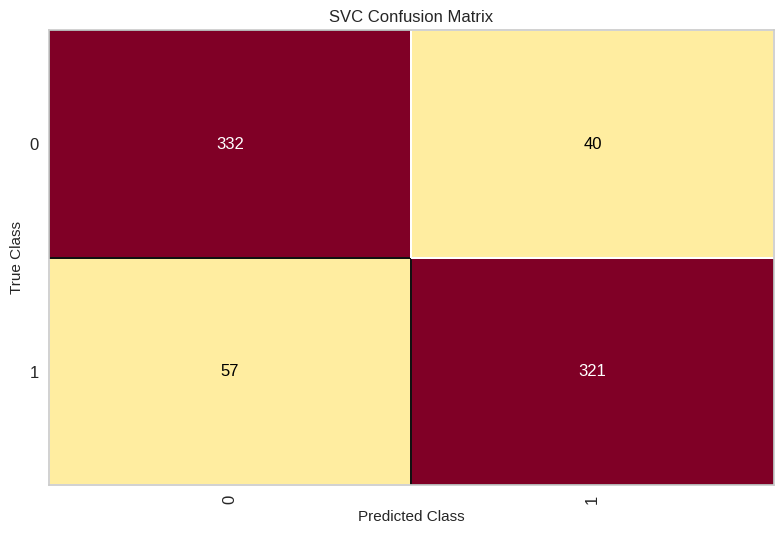

<Axes: title={'center': 'SVC Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [13]:
from yellowbrick.classifier import ConfusionMatrix

# Create a confusion matrix visualizer
cm_viz = ConfusionMatrix(svm_classifier, classes=svm_classifier.classes_)

# Fit the visualizer to the test data
cm_viz.score(test_embeddings, test_labels)

# Draw the confusion matrix
cm_viz.poof()

## ROC plot

ROC curves graphically illustrate a model's ability to discriminate between positive and negative classes across various thresholds. The ROC curve is created by plotting the true positive rate (sensitivity) against the false positive rate (1-specificity) at different threshold settings. This visualization allows analysts to assess a model's performance comprehensively, as it reveals how well the model balances its ability to correctly identify positive cases while minimizing false positives. A perfect model would yield an ROC curve that hugs the top-left corner, indicating high sensitivity and low false positives.

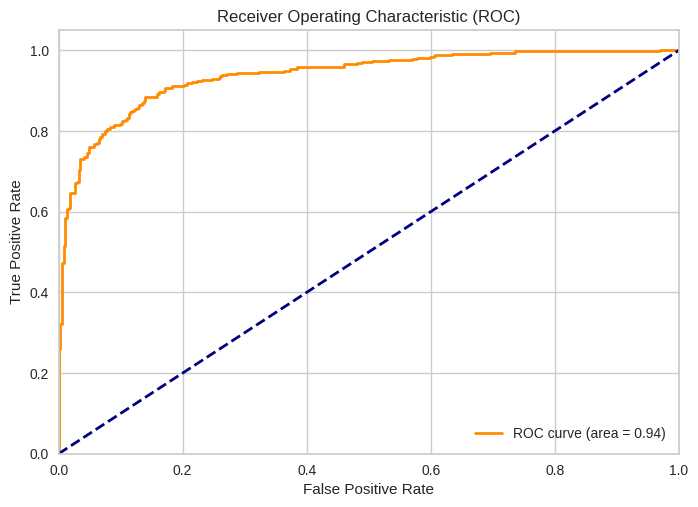

In [14]:
from sklearn import svm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Initialize and train SVM classifier with RBF kernel and probability=True
svm_classifier_rbf = svm.SVC(kernel="rbf", probability=True)
svm_classifier_rbf.fit(train_embeddings, train_labels)

# Predict probabilities for test data
test_probabilities = svm_classifier_rbf.predict_proba(test_embeddings)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(test_labels, test_probabilities[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

## Examining why model makes errors

The code below makes a visualisation that compares true positives to false positives. It shows which words are typical for false positives

To see the visualisation, run the code, download scattertext.html and view it in your browser.

The method works best with slightly larger datasets (at least 5,000 rows and over).

In [ ]:
# Limit DataFrame reviews that are actually NEGATIVE, regardless of whether
# the model made the right categorisation or not.
df = df[df['true_label'] == 0]

# Create a binary column to indicate whether the prediction is correct.
# I.e. we will be comparing true negatives and false negatives.
df['is_correct'] = df['prediction'] == df['true_label']
df['is_correct'] = df['is_correct'].astype(str)

# Convert to Scattertext Corpus
corpus = st.CorpusFromPandas(df,
                             category_col='is_correct',
                             text_col='text',
                             nlp=st.whitespace_nlp_with_sentences
                            ).build()

# Create a term frequency dataframe
term_freq_df = corpus.get_term_freq_df()

# Add a column for the frequency of each term in each category
term_freq_df['correct'] = corpus.get_scaled_f_scores('True')
term_freq_df['incorrect'] = corpus.get_scaled_f_scores('False')

# Get the terms that are most associated with each category
print("Terms most associated with correct predictions:")
print(term_freq_df.sort_values(by='correct', ascending=False).index[:10])
print("\nTerms most associated with incorrect predictions:")
print(term_freq_df.sort_values(by='incorrect', ascending=False).index[:10])

# Select terms which appear a minimum threshold in both corpora
compact_corpus = corpus.compact(st.ClassPercentageCompactor(term_count=10))

# Create a Scattertext plot
html = st.produce_scattertext_explorer(
    compact_corpus,
    category='True',
    category_name='Correct prediction',
    not_category_name='Wrong prediction',
    minimum_term_frequency=5,
    pmi_threshold_coefficient=5,
    width_in_pixels=1000,
    metadata=df['true_label']
)

# Save visualization to an HTML file
with open("scattertext.html", "w") as f:
    f.write(html)